# Testing Snake creation and evolution
Much (but not all) of this code will be duplicated to [main.py](../main.py)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy

import tsnake.initialize as init
from tsnake.snake import TSnake, Element, Node
from tsnake.grid import Grid, Point
from tsnake.utils import dist, seg_intersect


## Load images, compute masked reigons
### Link to images I used for the plane are [here](https://drive.google.com/open?id=1TK6rc-USD4KKI0Bss_B6r4l13oAD2uqG)

New image shape is (680, 680)
New mask shape is (680, 680)


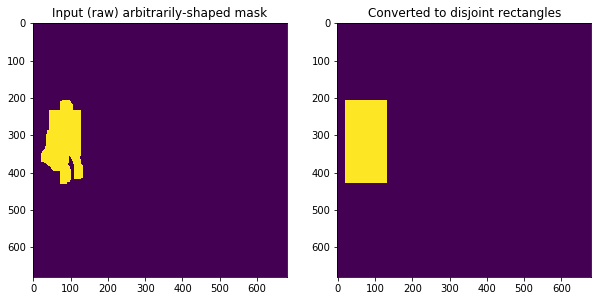

number of masked regions: 1


In [2]:
msk_path = '../examples/places2/case2_mask.png'
img_path = '../examples/places2/case2_raw.png'

mask = init.load_mask(path=msk_path, convert=True)
image = init.load_grayscale_image(img_path)

# Pad image to a square so ACID grid size can be upscaled
h, w = image.shape
if h > w:
    temp = np.ones((h, h))*255
    temp[:, :w] = image
    image = temp
else:
    temp = np.ones((w, w))*255
    temp[:h, :] = image
    image = temp

if mask is not None:
    temp = np.zeros(image.shape)
    if h > w:
        temp[:, :w] = mask
        mask = temp
    else:
        temp[:h, :] = mask
        mask = temp


print("New image shape is {}".format(image.shape))
print("New mask shape is {}".format(mask.shape))

regions = init._find_disjoint_masked_regions(mask)

# NOTE: Uncomment to visialize initial masked reigons
init.visualize_masked_regions(mask, regions)

regions = init.compute_masked_regions(image, mask)
print('number of masked regions:', len(regions))


## Initialize t-snakes
_Note: Length 17 t-snake (i.e. the sort one) is visibly wrong, not sure how we can fix that_
*Legend*
* Green lines: Normal vectors
* White Nodes: Initial 5 nodes of the snake
* Yellow Nodes: Final 5 nodes of the snake
    * This tells us which way the snake was initialized, Counter Clockwise or Clockwise

In [3]:
### Parameters for T-snakes ### 
N = image.shape[0]           # 30 nodes
p = 0.06        # scale for Eq (7)
c = 10.0         # scale for Eq (A.4)
a = 8.5          # tension param in Eq (8)
b = 16.0         # bending param in Eq (8)
q = 0.03         # scale for Eq (4)
gamma = 1.0      # friction param in Eq (8)
dt = 0.08        # step size in Eq (8)
sigma = 0.75      # gaussian filter param in Eq (A.4)
k = 0.5          # param k in Eq (6)

# region = compute_masked_regions(image, mask)[0]
# region.initialize_tsnake(N, p, c, sigma, a, b, q, gamma, dt)
# region.visualize()

# snake = region._initial_tsnake

tsnakes = []

for region in regions:
    tsnake = region.initialize_tsnake(
        N=N, p=p, c=c, sigma=sigma, a=a, b=b, q=q, gamma=gamma,
        dt=dt
    )
    tsnakes.append(tsnake)
#     region.visualize() # NOTE: To show tsnakes on images, uncomment

t_snake_lengths = [len(t.nodes) for t in tsnakes]
print('Length of T-Snakes initialized on image:\n{}'.format(t_snake_lengths))

Length of T-Snakes initialized on image:
[810]


## Create Grid

In [4]:
xdim, ydim = image.shape

print('image shape: ', image.shape)


image shape:  (680, 680)


In [5]:
scale=6
acid_grid = Grid(image=image, scale=scale)
print('Simplex grid shape: {}'.format(acid_grid.grid.shape))

Simplex grid shape: (114, 114)


## Test snake evolution

In [6]:
iterations = 10
target_region = 0
M = 10
# plot_grid = acid_grid # Uncomment and comment next line to plot ACID grid lines on image
plot_grid = None


region = regions[target_region]
init_snake = deepcopy(tsnakes[target_region])

for i in tqdm(range(iterations)):
    region_snake = tsnakes[target_region]
    # Run:
    # 1) the m-step function (which has M deformation steps), and
    # 2) the reparameterization (occuring every M deformation steps)
    region.show_snake(snake=region_snake, grid=plot_grid, save_fig='reparam/iter{}.0.png'.format(i))
    
#     print(len(region_snake.nodes))
    region_snake.m_step(M)
    region.show_snake(snake=region_snake, grid=plot_grid, save_fig='reparam/iter{}.1.png'.format(i))
    
    new_region_snakes, grid_node_queue = acid_grid.reparameterize_phase_one([region_snake])
    tsnakes[target_region] = new_region_snakes[0]
    region.show_snake(snake=tsnakes[target_region], grid=plot_grid, save_fig='reparam/iter{}.2.png'.format(i))
#     print(len(new_region_snakes[0].nodes))

final_snake = tsnakes[target_region]
    

Initial Snake


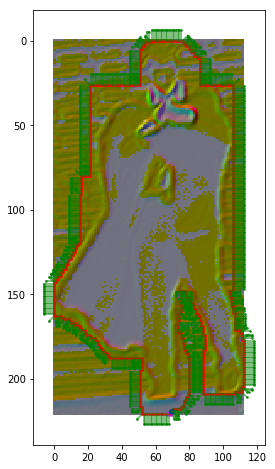

Final Snake


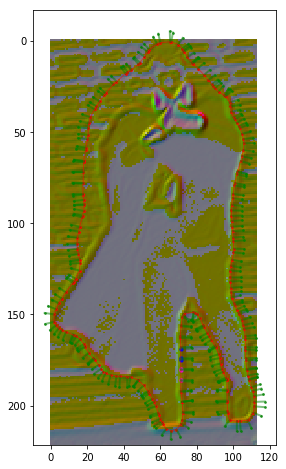

In [7]:
print("Initial Snake")
region.show_snake(snake=init_snake, grid=plot_grid)
print("Final Snake")
region.show_snake(snake=final_snake, grid=plot_grid)

In [8]:
def process_snake_for_mask_generation(snake, region):
        """
        For snake  goes through and returns a copy
        of it with its coordinate system changed to be consistent 
        with the entire image.
        (Each snake evolves in a coordinate system defined by its 
         respective MaskedRegion)
         
        Returns a new snake.
        """
            
        top_row = region.top_row
        left_col = region.left_col
            
        snake = deepcopy(snake)
        for node in snake.nodes:
            x, y = node.x, node.y
            x += top_row
            y += left_col
            node.update(x, y)
                
        return snake

In [9]:
def compare_masks(init_snake, final_snake, image_path, region, figsize=(15, 5), show_snakes=True):
    # ==========================================================
    # Compute the number of masked pixels per mask
    # number of masked pixels
#     npm_user = np.argwhere(self.user_mask != 0).shape[0]
#     npm_snake = np.argwhere(self.snake_mask != 0).shape[0]
    npm_user = init_snake.get_area()
    npm_snake = final_snake.get_area()
    
    pct_reduction = 100.0 *(npm_user - npm_snake) / npm_user
    # ==========================================================

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    f.suptitle('Percent reduction in masked pixels: %3f' % pct_reduction)
    ax1.set_title('Original image')
    ax2.set_title('User-defined mask (NPM=%d)' % npm_user)
    ax3.set_title('Snake-defined mask (NPM=%d)' % npm_snake)
    
    color_image = cv2.imread(image_path)

    # https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/
    ax1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    ax3.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

    if show_snakes:
        colors = ['red', 'blue']
        axs = [ax2, ax3]
        for i, snake in enumerate([init_snake, final_snake]):
            snake = process_snake_for_mask_generation(snake, region)
            node_locs = snake.node_locations

            axs[i].plot(
                node_locs[:, 1], node_locs[:, 0], color=colors[i], marker='.',
                linewidth=1, markersize=2
            )

    plt.tight_layout()
    plt.show()

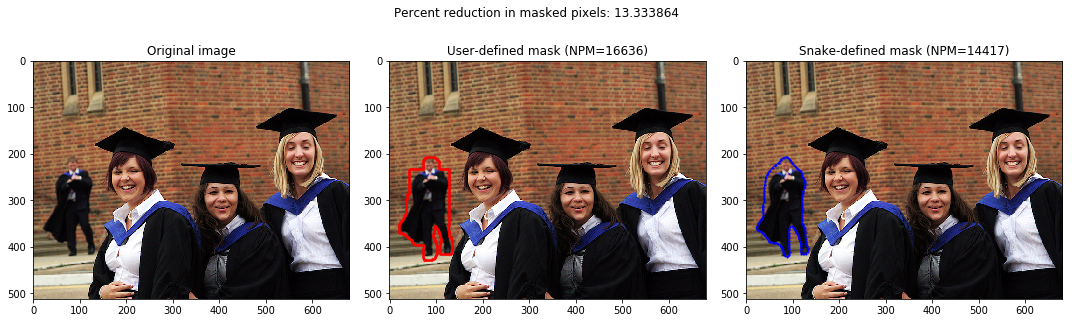

In [10]:
compare_masks(init_snake, final_snake, img_path, regions[target_region])